## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, factorial

## Constant definition and calculation

In [45]:
kB = 1.38065*10**(-23)   #unit-Joule/Kelvin
hbar = 1.05457*10**(-34)  #unit-Joule/Hz
lamb = 411*10**(-9)   #unit-m
amu = 1.66054*10**(-27)  #  kg
mass = 171  #171Yb+
frequency = 1.2504*10**6  #Hz

In [46]:
eta = 2*np.pi/lamb*np.sqrt(hbar/2/2/np.pi/mass/amu/frequency)*np.cos(np.pi/4)

In [47]:
eta

0.05255434338939188

## function definition

In [7]:
def pthermal_gen(nbar):
    plist = []
    i = 0
    while nbar**i/(nbar+1)**i > 0.01:
        plist.append(nbar**i/(nbar+1)**(i+1))
        i += 1
    return np.array(plist)

In [8]:
def Omegarsb(eta, Omega, n):
    return 2*np.pi*Omega*np.exp(-eta**2/2)*np.sqrt(np.array(factorial(n-1, exact=True)/factorial(n, exact=True)).astype(float))*eta*genlaguerre(n-1, 1)(eta**2)

In [9]:
plist = pthermal_gen(10)

In [10]:
np.sum(plist)

0.9906295935925492

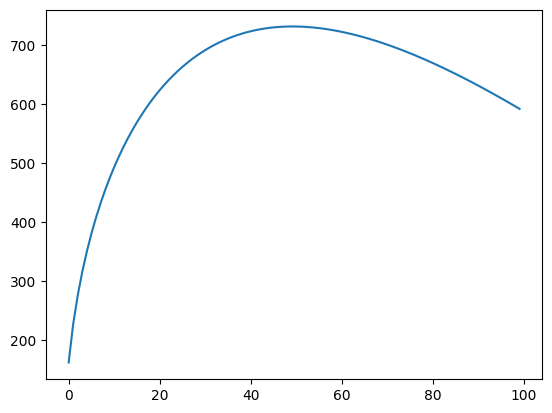

In [11]:
omega = []
N=100
for n in range(N):
    omega.append(Omegarsb(0.13, 200, n+1))
plt.plot(range(N), omega)

In [12]:
def SBC_FO_once_M(t, plist, eta, Omega):
    n = len(plist)
    W_mat = np.zeros((n,n))
    for i in range(n):
        if i == 0:
            ai = 1
            bi1 = np.sin(Omegarsb(eta, Omega, 1)*t/2)**2
        else:
            ai = np.cos(Omegarsb(eta, Omega, i)*t/2)**2
            bi1  = np.sin(Omegarsb(eta, Omega, i+1)*t/2)**2
        W_mat[i, i] = ai
        if i < n-1:
            W_mat[i, i+1] = bi1
            
    return W_mat

In [13]:
def heating_matrix(t, plist, gamma):
    n = len(plist)
    H_mat = np.zeros((n,n))
    
    transition_rate_thr = 0.2
    dt = transition_rate_thr/gamma/(2*n + 1)
    m = int(t/dt) + 1
    dt = np.min([t, dt])
    for i in range(n):
        if i == n-1:
            H_mat[i, i-1] = gamma*i*dt
            H_mat[i, i] = -gamma * (2*i+1) *dt
        elif i == 0:
            H_mat[i, i] = -gamma * (2*i+1) *dt
            H_mat[i, i+1] = gamma * (i+1) *dt
        else:
            H_mat[i, i-1] = gamma*i *dt
            H_mat[i, i] = -gamma * (2*i+1) *dt
            H_mat[i, i+1] = gamma * (i+1) *dt

    return np.linalg.matrix_power(np.eye(n)+H_mat, m)

In [14]:
M = SBC_FO_once_M(0.01, plist, 0.05, 200)

In [15]:
M20 = M**25

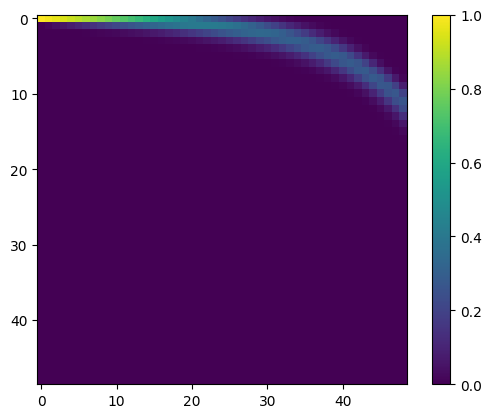

In [16]:
# plt.figure(figsize=(10,10))
plt.imshow(np.linalg.matrix_power(M, 40))
plt.colorbar()

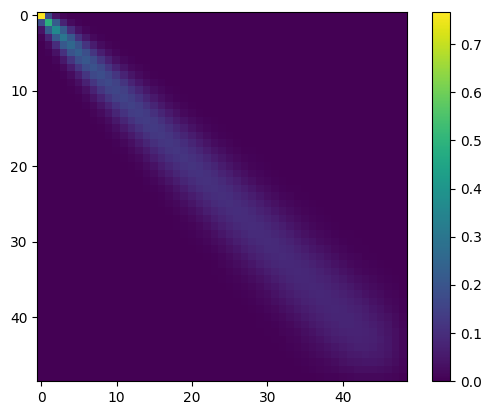

In [17]:
# plt.figure(figsize=(10,10))
plt.imshow(np.linalg.matrix_power(heating_matrix(0.05, plist, 0.2), 30))
plt.colorbar()

In [18]:
heating_matrix(0.01, plist, 0.2)[:, 5]

array([0.   , 0.   , 0.   , 0.   , 0.01 , 0.978, 0.012, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   ])

In [19]:
def nbar_after_SBC(t, plist_init, eta, Omega, Ncycle):
    W_mat = SBC_FO_once_M(t, plist_init, eta, Omega)
    W_tot = np.linalg.matrix_power(W_mat, Ncycle)
    
    plist_final = W_tot @ plist_init
    nlist = np.array(range(len(plist_final)))
    
    nbar_final = np.sum(nlist*plist_final)
    p_tot = np.sum(plist_final)
    return nbar_final, plist_final, p_tot

In [20]:
def nbar_after_SBCheating(t, plist_init, t_wait, eta, Omega, gamma, Ncycle):
    W_mat = SBC_FO_once_M(t, plist_init, eta, Omega)
    H_mat = heating_matrix(t, plist_init, gamma)
    H_mat_wait = heating_matrix(t_wait, plist_init, gamma)
    M_tot_m = H_mat_wait @ (W_mat @ H_mat+H_mat @ W_mat)/2
    # print(np.sum((W_mat @ H_mat)[:, 5]))
    
    M_tot = np.linalg.matrix_power(M_tot_m, Ncycle)
    
    plist_final = M_tot @ plist_init
    nlist = np.array(range(len(plist_final)))
    
    nbar_final = np.sum(nlist*plist_final)
    p_tot = np.sum(plist_final)
    return nbar_final, plist_final, p_tot, M_tot

In [21]:
plist_init = pthermal_gen(15)
nbar, plist, p_tot = nbar_after_SBC(0.05, plist_init, 0.05, 100, 40)

In [22]:
nbar

7.415578588299305

In [23]:
plist_init = pthermal_gen(12)
nbar, plist, p_tot, M_tot = nbar_after_SBCheating(0.04, plist_init, 0.07, 0.038, 71.4, 0.2, 70)

In [22]:
nbar

0.2776156099334468

## Gradient descent

In [24]:
def gradient_descent(f, k, dx_eps, y_eps, x, dx):
    y0 = f(x)
    N = 0
    while (np.abs(dx) > dx_eps) and (y0 > y_eps):
        y1 = f(dx+x)
        df = y1 - y0
        x = x + dx
        dx = -k*df/dx
        y0 = y1
        N += 1
        # print(dx)
        
        if N > 1000:
            print("not found the optimal value in 1000 trial")
            break
        
    return y0, x, N

In [25]:
def gradient_descent_mp(f, dx_eps, y_eps, k, x, dx, lower_bound, upper_bound):
    assert len(x)==len(dx)
    
    x = np.array(x)
    dx = np.array(dx)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)
    n = len(x)
    basis = np.eye(n)
    dy_basis = np.zeros(n)
    y0 = f(x)
    N = 0
    y = [y0]
    while (np.sqrt(np.sum(dx**2)) > dx_eps) and (y0 > y_eps):

        if np.sum(((x+dx)>lower_bound) & ((x+dx)<upper_bound)) == n:
            for i in range(n):
                dy_basis[i] = f(dx*basis[i, :]+x) - y0
            x = x + dx
            y0 = f(x)
            dx = -k*dy_basis/dx
        elif np.sum((x+dx)>lower_bound) < n:
            for i in range(n):
                dx[i] = np.max((lower_bound-x)[i], dx[i])
            for i in range(n):
                dy_basis[i] = f(dx*basis[i, :]+x) - y0
            x = x + dx
            y0 = f(x)
            dx = -k*dy_basis/dx
        
        else:
            for i in range(n):
                dx[i] = np.min((upper_bound-x)[i], dx[i])
            for i in range(n):
                dy_basis[i] = f(dx*basis[i, :]+x) - y0
            x = x + dx
            y0 = f(x)
            dx = -k*dy_basis/dx 
            
        y.append(y0)
        N += 1
        
        
        if N > 1000:
            print("not found the optimal value in 1000 trial")
            break
        
    return y, x, N

In [50]:
def cost_func(t):
    Ncycle = 10  # number of pulsed SBC cycle
    Omega = 126 #78.4  #kHz
    nbar_init = 0.5  #average phonon num after Doppler cooling
    t_wait = 0.040
    eta = 0.0525543433893918  
    gamma = 0.002
    plist_init = pthermal_gen(nbar_init)
    # nbar_final, plist, p_tot = nbar_after_SBC(t, nbar_init, eta, Omega, Ncycle)  #t unit-ms
    
    nbar_final, plist, p_tot, M_tot = nbar_after_SBCheating(t, plist_init, t_wait, eta, Omega, gamma, Ncycle)  #t unit-ms
    
    return nbar_final

In [26]:
def cost_func_mp(t):
    Ncycle = 60  # number of pulsed SBC cycle
    Omega = 172#71.4  #kHz
    nbar_init = 12  #average phonon num after Doppler cooling
    t_wait = 0.040
    eta = 0.049  
    gamma = 0.002
    m = Ncycle//len(t)
    Nres = Ncycle%len(t)
    plist_init = pthermal_gen(nbar_init)
    # nbar_final, plist, p_tot = nbar_after_SBC(t, nbar_init, eta, Omega, Ncycle)  #t unit-ms
    for i in range(len(t)):
        if i == 0:
            n_seg = m + Nres
        else:
            n_seg = m
        
        nbar_final, plist, p_tot, M_tot = nbar_after_SBCheating(t[i], plist_init, t_wait, eta, Omega, gamma, n_seg)  #t unit-ms
        plist_init = plist
    
    return nbar_final

In [27]:
y, x, N = gradient_descent_mp(cost_func_mp, 1e-5, 0.007, 1e-5, [0.009, 0.012, 0.022], [0.004, 0.004, 0.004], [0.0, 0.0, 0.0], [0.02, 0.04, 0.06])

In [97]:
x  #70 cycle

array([0.0096269 , 0.01215545, 0.01960246])

In [28]:
x

array([0.0092852 , 0.01196123, 0.02180884])

In [29]:
y[-1]

0.007989914958915809

In [30]:
cost_func_mp([0.0093, 0.0119, 0.0218])

0.007993077591723265

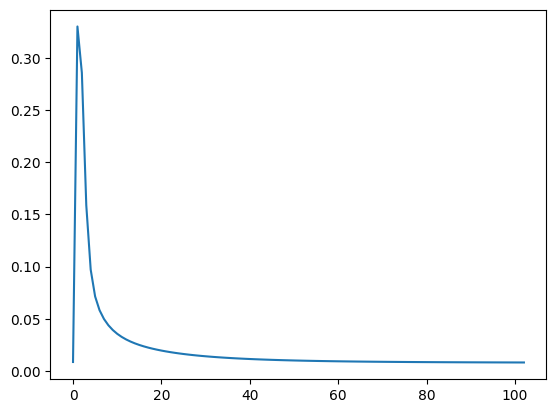

In [31]:
plt.plot(y)

In [44]:
N

39

In [46]:
y[38]

0.6854960799886084

In [45]:
x

array([0.01168712, 0.03056206, 0.04278462])

In [84]:
y, x, N = gradient_descent(cost_func, 1e-6, 1e-7, 0.1, 0.02, 0.002)

In [85]:
y

0.11339761519667392

In [86]:
N

108

In [87]:
x

0.012716705639289243

In [88]:
nbar_final, plist, p_tot, M_tot = nbar_after_SBCheating(0.0115, pthermal_gen(12), 0.04, 0.0405, 227, 0.002, 60)

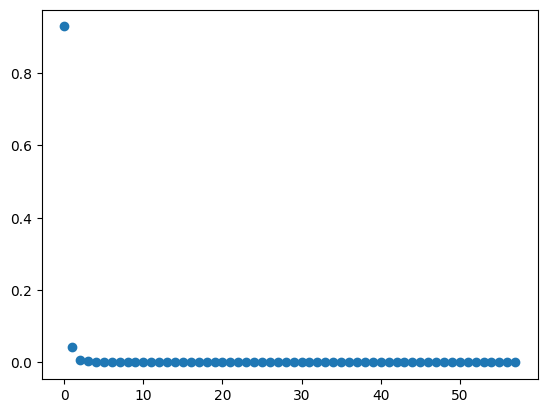

In [89]:
plt.plot(plist, 'o')

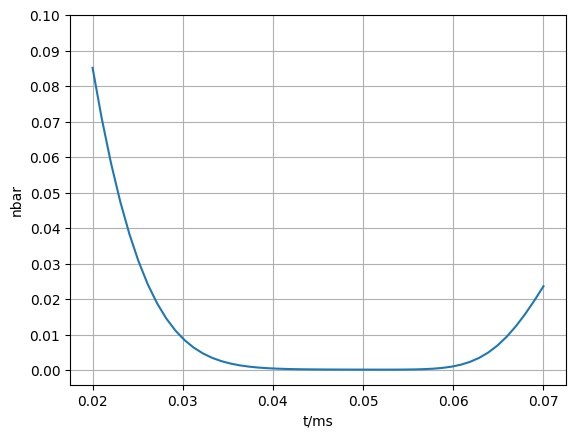

In [51]:
tlist = np.linspace(0.02, 0.07, 50)
nlist = []
for t in tlist:
    nlist.append(cost_func(t))
plt.plot(tlist, nlist)
plt.xlabel("t/ms")
plt.ylabel("nbar")
plt.yticks(np.linspace(0, 0.1, 11))
plt.grid(True)

0.1276222277866072


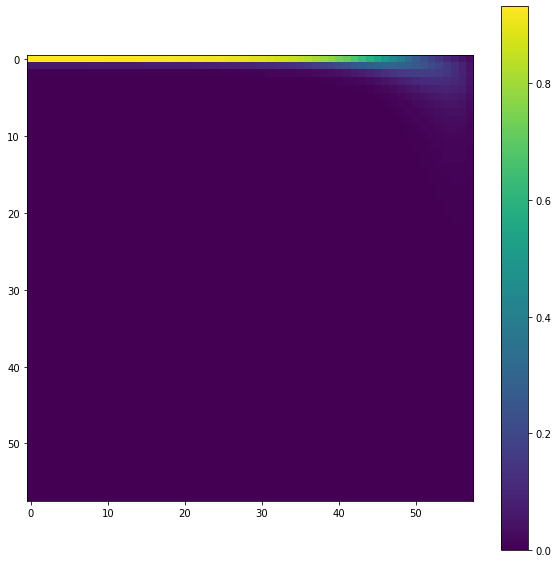

In [75]:
nbar_final, plist, p_tot, M_tot = nbar_after_SBCheating(0.04, 12, 0.038, 71.4, 0.2, 70)
print(nbar_final)
plt.figure(figsize=(10, 10))
plt.imshow(M_tot)
plt.colorbar()

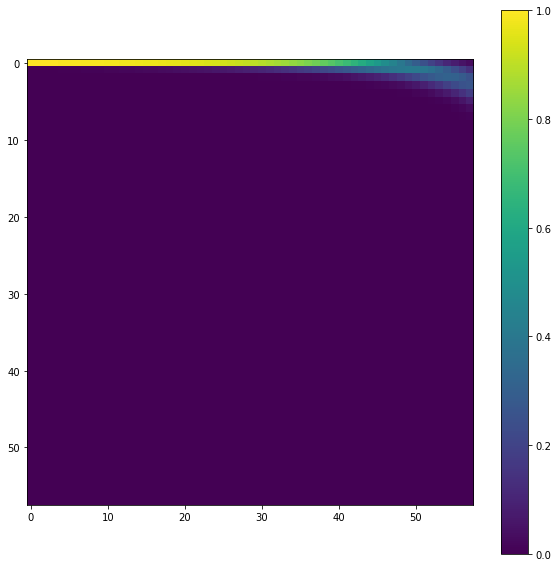

In [274]:
plist = pthermal_gen(12)
M = SBC_FO_once_M(0.02, plist, 0.05, 100)
M_tot = np.linalg.matrix_power(M, 70)
plt.figure(figsize=(10, 10))
plt.imshow(M_tot)
plt.colorbar()

In [65]:
1/(0.038*71.4*np.sqrt(12))

0.10639655557821498